# Homework 2 - Machine Learning Pipeline

## Read and Explore Data

In [135]:
% run util.py
% matplotlib inline

In [122]:
credit = read_file('data/credit-data.csv', 'csv', 'PersonID') 
data_dict = read_file('data/Data Dictionary.xls', 'excel')
d = create_data_dic(data_dict)
cdf = credit.copy() # making a copy of the original data in its unadulterated form

Thanks to Vidal, I discover a magical pandas library called pandas_profiling, which has a built-in function that runs summary statistics on ALL of your data.

In [97]:
from pandas_profiling import ProfileReport

In [101]:
ProfileReport(cdf)

Number of variables,13
Number of observations,41016
Total Missing (%),1.7%
Total size in memory,4.1 MiB
Average record size in memory,104.0 B
Numeric,10
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,2


Just checking manually that the ProfileReport was correct.

In [123]:
check_missing(credit)

'There are no missing values.'

Let's take a deeper look into those variables with missing values.

In [105]:
credit.NumberOfDependents.value_counts()

0     24540
1      7211
2      5539
3      2666
4       786
5       201
6        51
7        12
8         7
9         2
13        1
Name: NumberOfDependents, dtype: int64

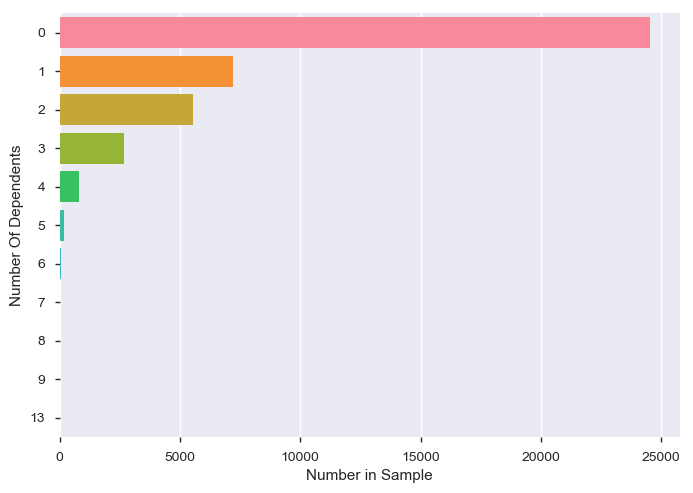

In [106]:
col_to_hist(credit, 'NumberOfDependents', 'Number Of Dependents', sort=True)

Since number of dependents are integer values, we will fill the null values with the median. We will also change the data type from float to integer.

In [103]:
impute_missing(credit, 'NumberOfDependents', 'median')
credit.NumberOfDependents = credit.NumberOfDependents.astype(int)

In [104]:
credit.NumberOfDependents.dtype

dtype('int64')

Because Income is highly skewed by extreme outliers, I impute the null values in monthly income using the median instead of the mean.

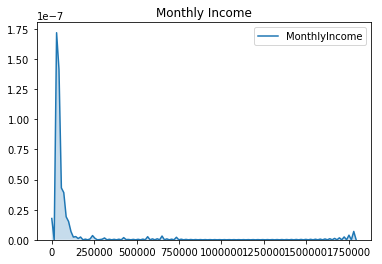

In [23]:
density_plot(credit, 'MonthlyIncome', d)

In [21]:
impute_missing(credit, 'MonthlyIncome', 'median')

We also cap the monthly income with 99.9% quantile value as the maximum, which was $75,000 in this case.

In [35]:
cap_outlier(credit, 'MonthlyIncome')

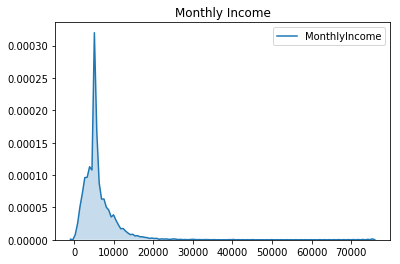

In [36]:
density_plot(credit, 'MonthlyIncome', d)

We should have no more missing values.

In [121]:
check_missing(credit)

'There are no missing values.'

In [39]:
credit.age.describe()

count    41016.000000
mean        51.683489
std         14.746880
min         21.000000
25%         41.000000
50%         51.000000
75%         62.000000
max        109.000000
Name: age, dtype: float64

In [40]:
discretize_var(credit, 'age', 10)

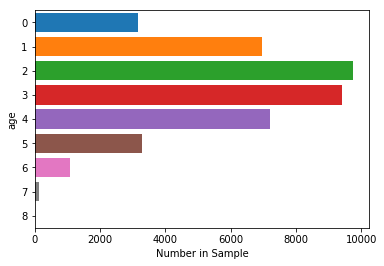

In [45]:
col_to_hist(credit, 'age_bin', 'age', sort=False)

In [53]:
discretize_var(credit, 'MonthlyIncome', 2000)

In [54]:
credit.MonthlyIncome_bin.unique()

[0, 7, 2, 4, 5, ..., 35, 28, 23, 29, 26]
Length: 38
Categories (38, int64): [0 < 1 < 2 < 3 ... 34 < 35 < 36 < 37]

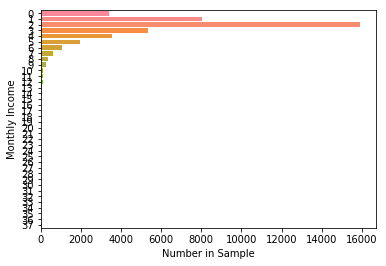

In [55]:
col_to_hist(credit, 'MonthlyIncome_bin', 'Monthly Income', sort=False)

In [38]:
credit.SeriousDlqin2yrs.value_counts()

0    34396
1     6620
Name: SeriousDlqin2yrs, dtype: int64

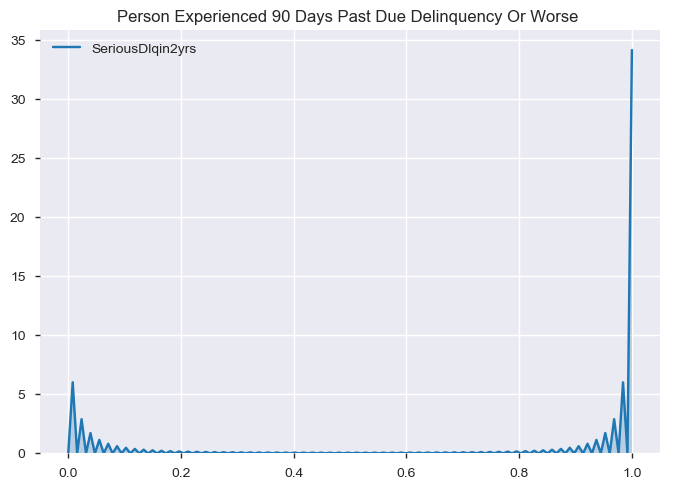

In [107]:
density_plot(credit, 'SeriousDlqin2yrs', d)

The following 3 variables are HIGHLY correlated.
- 'NumberOfTime30-59DaysPastDueNotWorse': Number Of Times Borrower Has Been 30-59 Days Past Due But No Worse In The Last 2 Years.
- 'NumberOfTime60-89DaysPastDueNotWorse': Number Of Times Borrower Has Been 60-89 Days Past Due But No Worse In The Last 2 Years.'
- 'NumberOfTimes90DaysLate': Number Of Times Borrower Has Been 90 Days Or More Past Due.

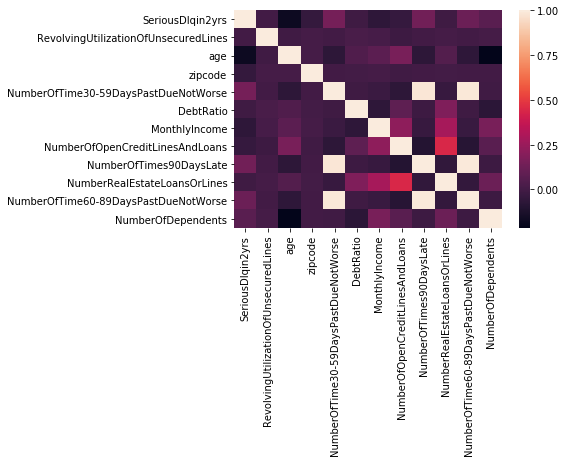

In [56]:
corr_matrix(credit)

In [57]:
x_train, x_test, y_train, y_test = split_data(credit)

In [160]:
top_model, eval_df = knn_models(x_train, y_train, x_test, y_test)

In [162]:
top_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=1,
           weights='uniform')

In [165]:
eval_df.head()

,k,metric,p,weight_fcn,accuracy_score
0,1,minkowski,1,uniform,0.784072
1,1,minkowski,2,uniform,0.770744
2,1,minkowski,3,uniform,0.767493
3,1,minkowski,4,uniform,0.767087
4,1,minkowski,5,uniform,0.766599


Using the top model selected above (fit on training data, and evaluated on performance on testing data), we run the model again to get into the details of how the data is being classified.

We first look at the accuracy of the model on the data that we trained on. The accuracy score should be fairly high.

In [195]:
result_on_train = just_predict(top_model, x_train, y_train, x_train, y_train)

In [196]:
validate(result_on_train.actual, result_on_train.predicted)

Accuracy Score: 0.8424993904775173


,predicted_no,predicted_yes
actual_no,24001,41
actual_yes,4481,188


We then look at the accuracy of the model on the subset of the data that we held out to test the generalizability of the model. 

In [197]:
result_on_test = just_predict(top_model, x_train, y_train, x_test, y_test)

In [198]:
result_on_test.filter(['actual', 'predicted']).head()

,actual,predicted
PersonID,,
125433,0,0
130505,0,0
108280,0,0
109970,0,0
138333,1,0


In [200]:
val = validate(result_on_test.actual, result_on_test.predicted)
val

Accuracy Score: 0.842015440877692


,predicted_no,predicted_yes
actual_no,10321,33
actual_yes,1911,40


Now we can calculate the precision, recall, and F1 score (the harmonic mean of precision and recall) using the confusion matrix above.
- Precision: when our classifier classifies something as positive, how likely is it that the prediction is correct?
    - true positive / total classified positive 
- Recall: for all actual positive values, how likely is our predictor to predict it as True?
    - true positive / total actual positive

In [201]:
F1_score(val)

Precision: 0.547945205479452 
Recall: 0.020502306509482315


0.039525691699604744